# Coal production in mines 2013

by: Segun Adelowo

Abstract: We did a a number of analysis and arrived at some interesting conclusions

In [13]:
%matplotlib inline

import string

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

sns.set();

## Cleaned Data

Cleaned this data in the notebeook stored in: deliver/Data_cleaning.ipynb

In [14]:
df = pd.read_csv("../data/cleaned_coalpublic2013.csv", index_col='MSHA ID')
df[['Year','Mine_Name']].head()

,Year,Mine_Name
MSHA ID,,
103381,2013,Tacoa Highwall Miner
103404,2013,Reid School Mine
100759,2013,North River #1 Underground Min
103246,2013,Bear Creek
103451,2013,Knight Mine


# Predict the Production of coal mines

In [15]:
# The values are numeric
features = ['Average_Employees',
            'Labor_Hours'
           ]

In [16]:
# The values are non numeric
categoricals = ['Mine_State',
                'Mine_County',
                'Mine_Status',
                'Mine_Type',
                'Company_Type',
                'Operation_Type',               
                'Union_Code',
                'Coal_Supply_Region'        
               ]

In [17]:
target = 'log_production'

# Take a look at the interplay between each of the varables and the target variable

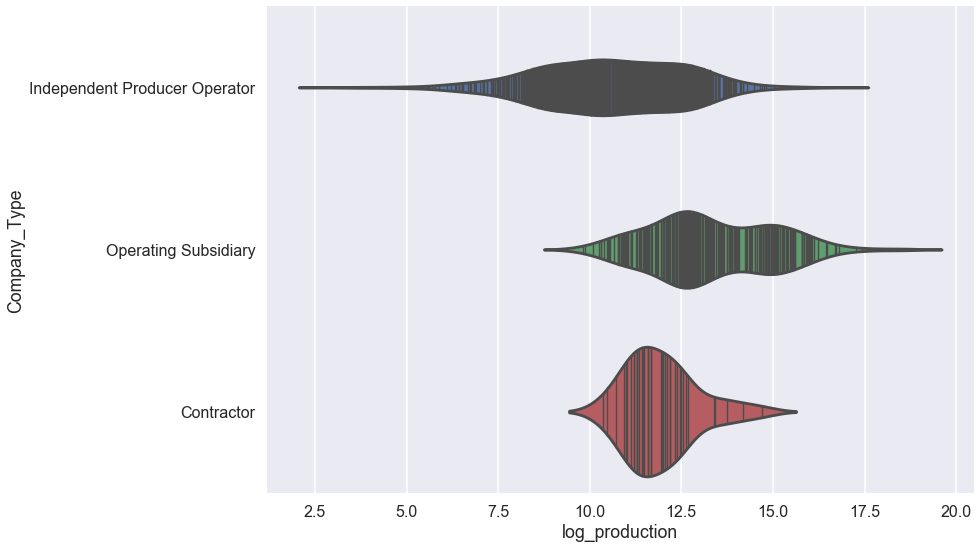

In [18]:
sns.set_context('poster')
fig = plt.subplots(figsize=(14,8))
sns.violinplot(y="Company_Type",x="log_production", data=df, split=True, inner="stick");
plt.tight_layout()
plt.savefig("../figures/Coal_prediction_company_type_vs_log_production.png")

In [19]:
dummy_categoricals = []
for categorical in categoricals:   
    # Avoid the dummy variable trap!
    drop_var= sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical],prefix=categorical)
    df=pd.concat([df,temp_df],axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

# Build Model (Random Forest Regressor)

In [20]:
train, test = train_test_split(df, test_size=0.3)

In [21]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(train[features + dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

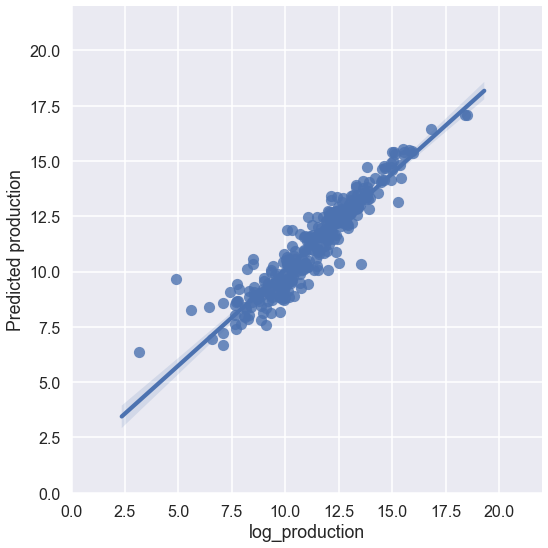

In [22]:
fig=plt.subplots(figsize=(8,8))
sns.regplot(test[target], rf.predict(test[features + dummy_categoricals]))
plt.ylabel("Predicted production")
plt.xlim(0,22)
plt.ylim(0,22)
plt.tight_layout()
plt.savefig("../figures/Coal_production_RF_prefiction.png")

### Look at how good this is a fit and not just look a plot and say it is good

In [23]:
predicted = rf.predict(test[features+dummy_categoricals])
print ("R^2 score:", r2_score(test[target], predicted))
print ("MSE: ",mean_squared_error(test[target],predicted))

R^2 score: 0.870789480478
MSE:  0.616036319034


In [24]:
rf_importances = pd.DataFrame({'name':train[features + dummy_categoricals].columns,
                               'importance':rf.feature_importances_
                              }).sort_values(by='importance',ascending=False).reset_index(drop=True)
rf_importances.head(5)  #how predictive the items are

,importance,name
0,0.860815,Labor_Hours
1,0.040339,Average_Employees
2,0.006377,Mine_Type_Surface
3,0.005978,Coal_Supply_Region_Powder River Basin
4,0.003803,Mine_State_West Virginia (Southern)


# Conclusion

